<a href="https://colab.research.google.com/github/shift-13/Geo/blob/main/Geo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построем модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

**Описание данных**  
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек;
* `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Загрузка и подготовка данных

### Импорт библиотек

Загрузка библиотеки для отчета.

In [25]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pandas as pd

import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, train_test_split
from numpy.random import RandomState

### Первый датасет

In [27]:
try:
  !gdown --id 1vv4kTePQABbU3Dqy3LlUyvkkrBJUkTf4
  data_0 = pd.read_csv('geo_data_0.csv')
except:
  data_0 = pd.read_csv('/datasets/geo_data_0.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vv4kTePQABbU3Dqy3LlUyvkkrBJUkTf4
To: /content/geo_data_0.csv
100% 8.21M/8.21M [00:00<00:00, 111MB/s]


Выведем основную информацию.

In [28]:
def info(data):
  display(data.head())
  print()
  print(data.info())
  print()
  print('Количество дубликатов:', data.duplicated().sum())
  print()
  print('Количество пропусков', data.isna().sum(), sep='\n')
  print()
  print('Значения целевого признака:')
  sns.boxplot(x=data['product'])
  plt.show()
  print('Тепловая карта:')
  sns.heatmap(data.corr(), annot=True)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество дубликатов: 0

Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Значения целевого признака:


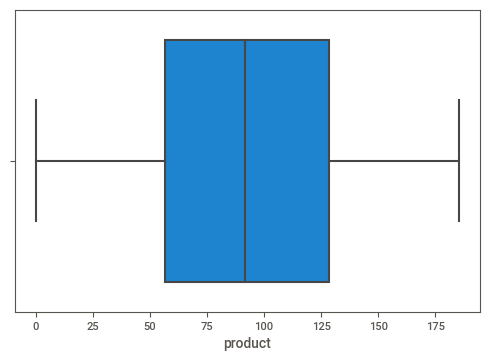

Тепловая карта:


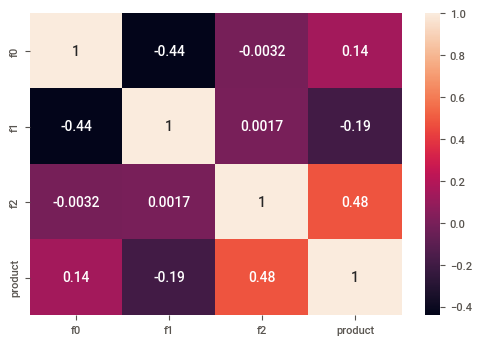

In [29]:
info(data_0)

Видим сильную обратную зависимость между признаками f0 и f1(-0.44). Так же f2 сильно коррелирует с целевым признаком(0.48).

### Второй датасет

In [30]:
try:
  !gdown --id 18ELJD0kalEAaCVOcwl4JdJW_qgT-xyWa
  data_1 = pd.read_csv('geo_data_1.csv')
except:
  data_1 = pd.read_csv('/datasets/geo_data_1.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18ELJD0kalEAaCVOcwl4JdJW_qgT-xyWa
To: /content/geo_data_1.csv
100% 8.03M/8.03M [00:00<00:00, 98.1MB/s]


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество дубликатов: 0

Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Значения целевого признака:


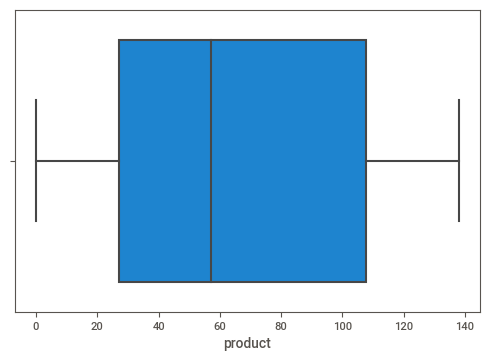

Тепловая карта:


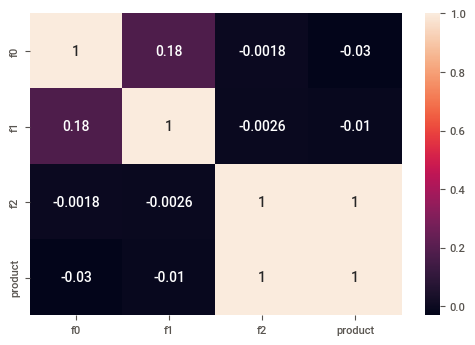

In [31]:
info(data_1)

Здесь прямая линейная зависимость между признаком f2 и целевым(1). Так же есть связь между признаками f1 и f0.

### Третий датасет

In [32]:
try:
  !gdown --id 1fOCUpYBvkKsC2P35H-Lazz53-XtCrh7g
  data_2 = pd.read_csv('geo_data_2.csv')
except:
  data_2 = pd.read_csv('/datasets/geo_data_2.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fOCUpYBvkKsC2P35H-Lazz53-XtCrh7g
To: /content/geo_data_2.csv
100% 8.19M/8.19M [00:00<00:00, 91.6MB/s]


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество дубликатов: 0

Количество пропусков
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Значения целевого признака:


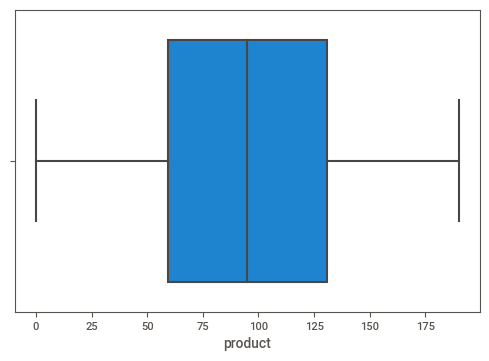

Тепловая карта:


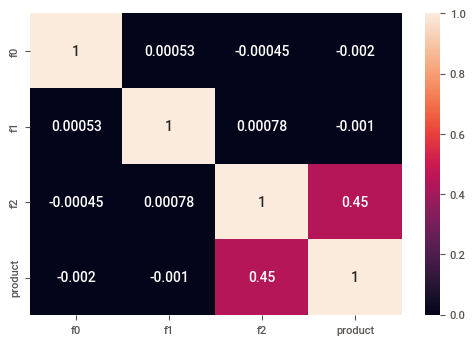

In [33]:
info(data_2)

Здесь признаки между собой почти не коррелируют, но f2 имеет зависимость с product(0.45).

In [34]:
report_0 = sv.compare([data_0, "Регион 1"], [data_1, 'Регион 2'])

                                             |          | [  0%]   00:00 -> (? left)


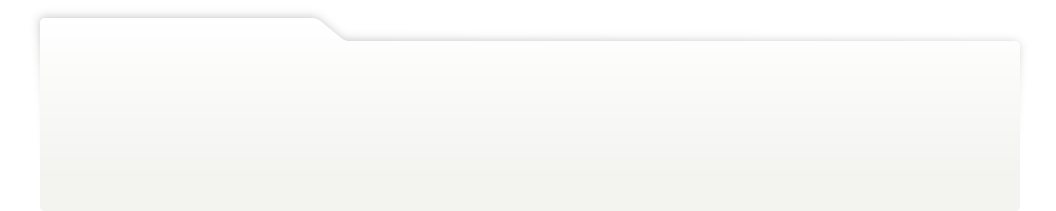
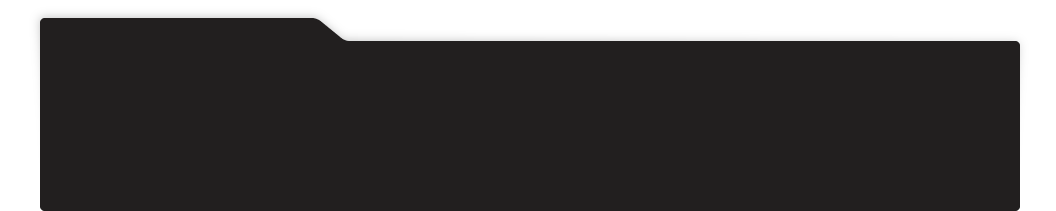
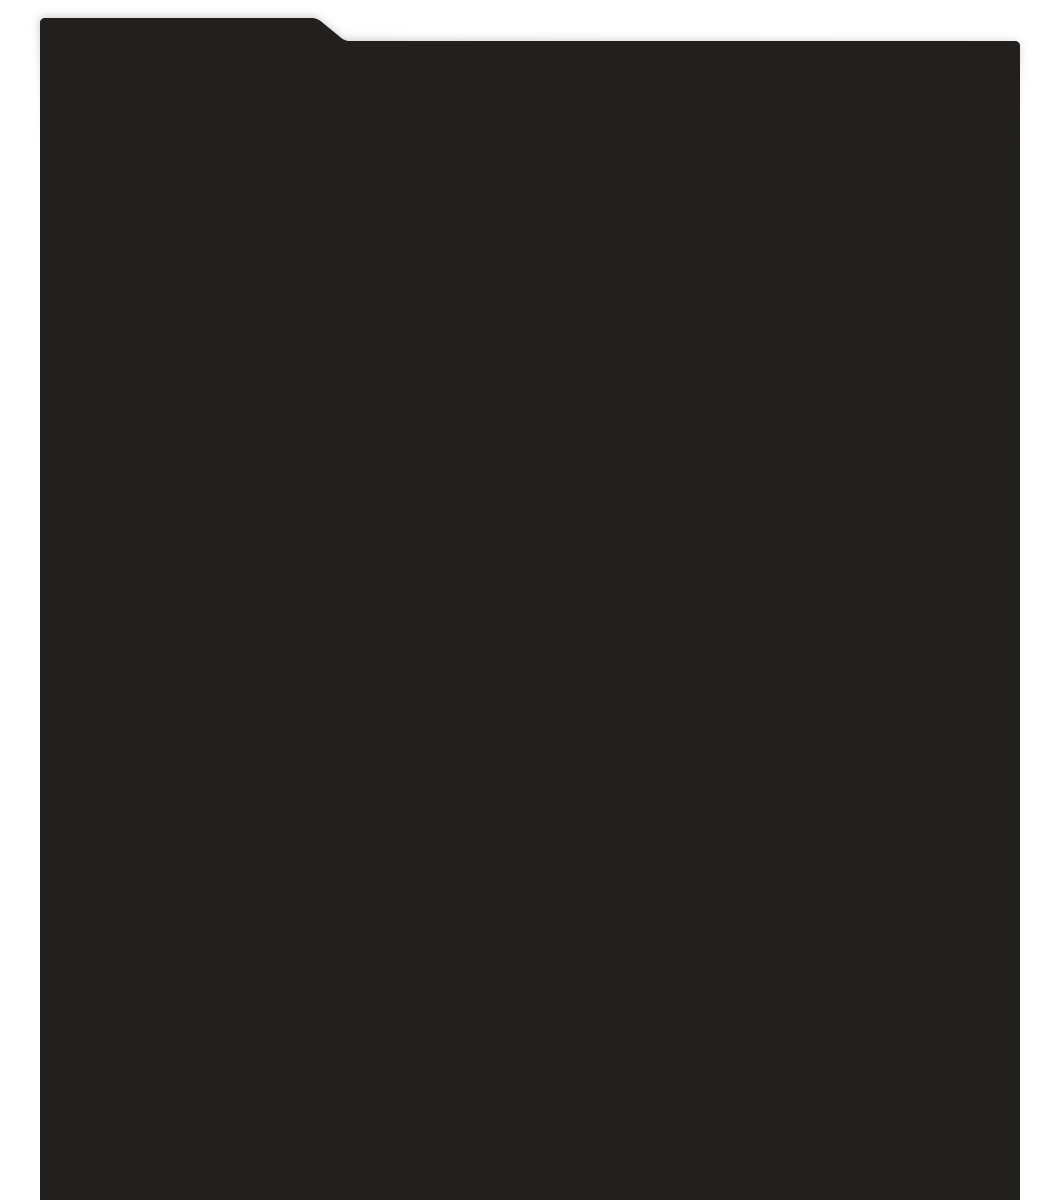
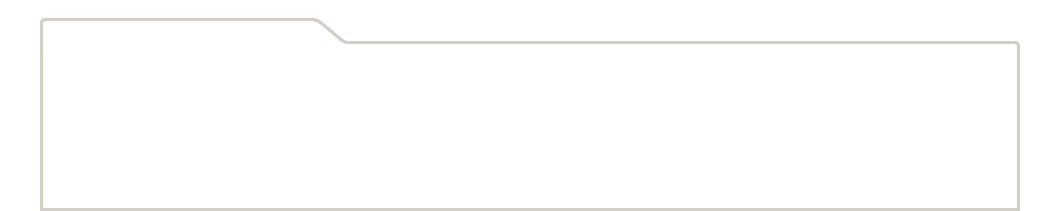
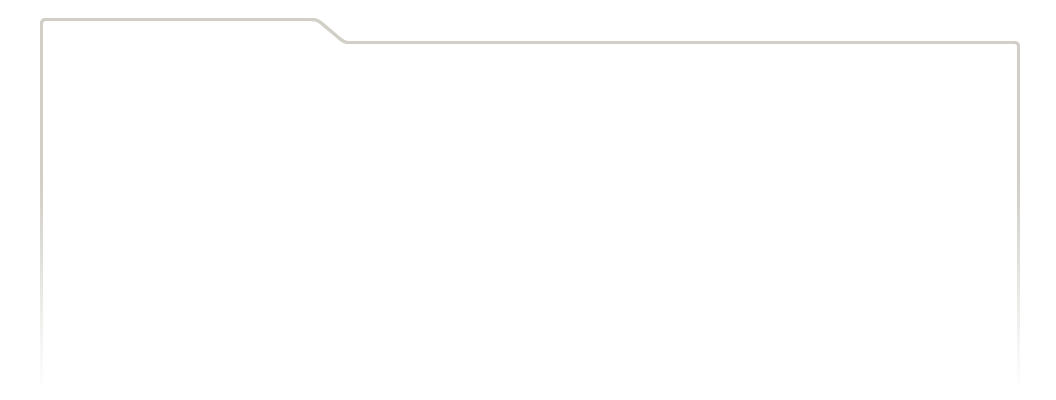
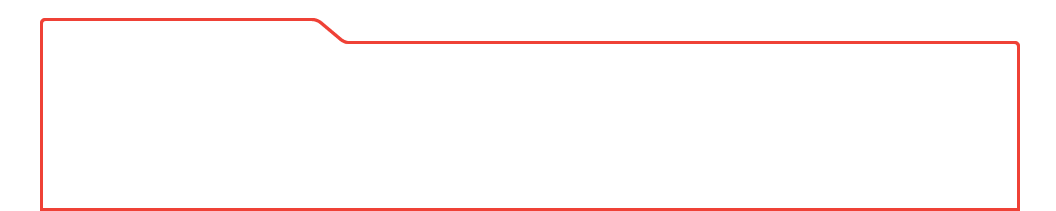
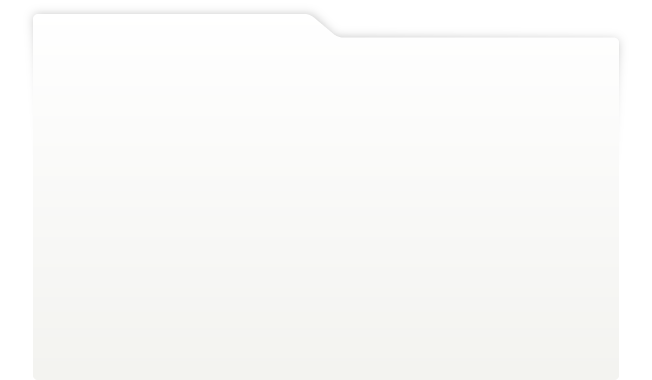
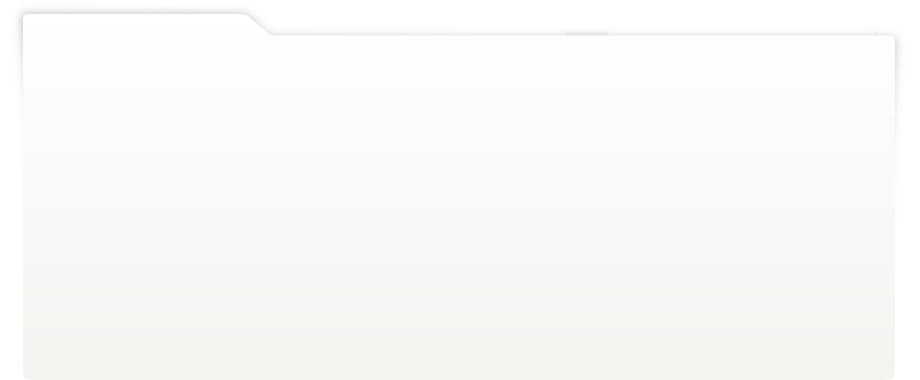
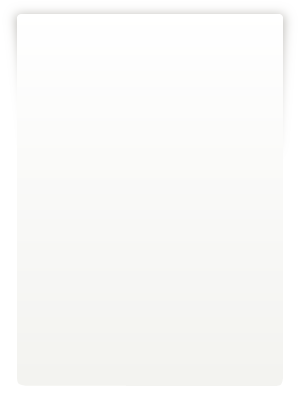
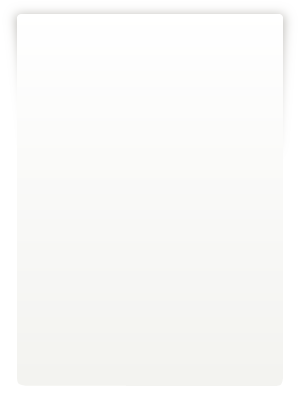
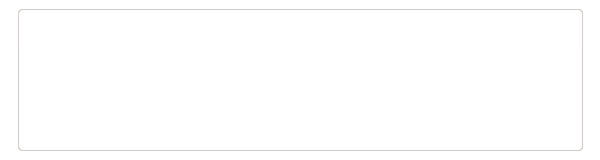
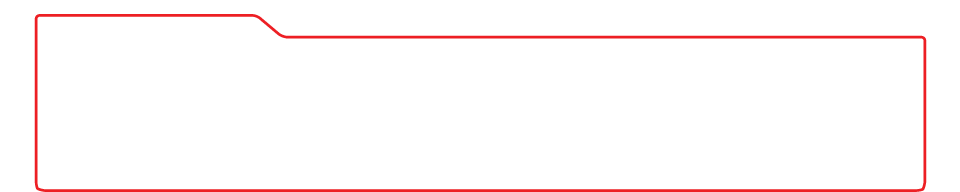
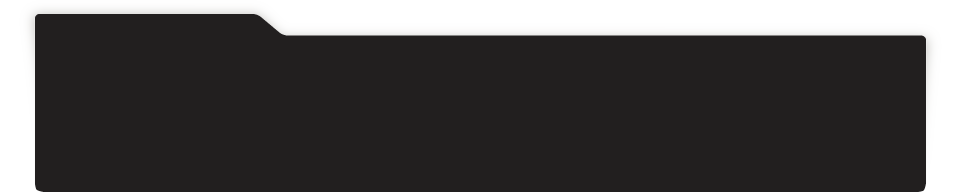
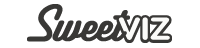
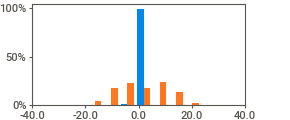
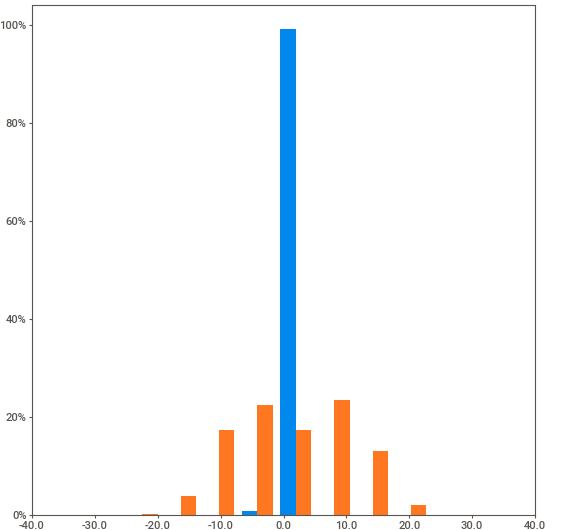
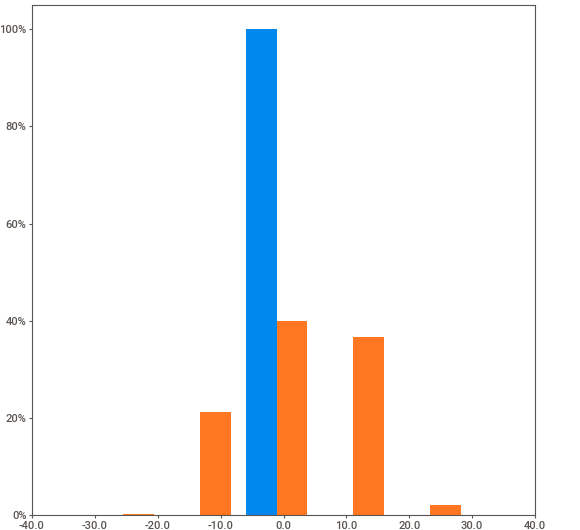
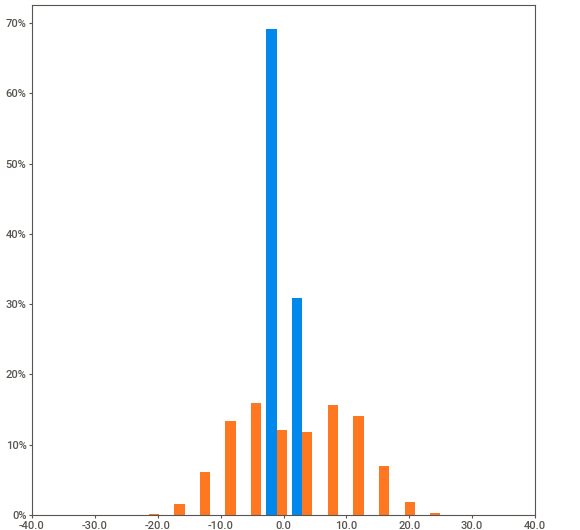
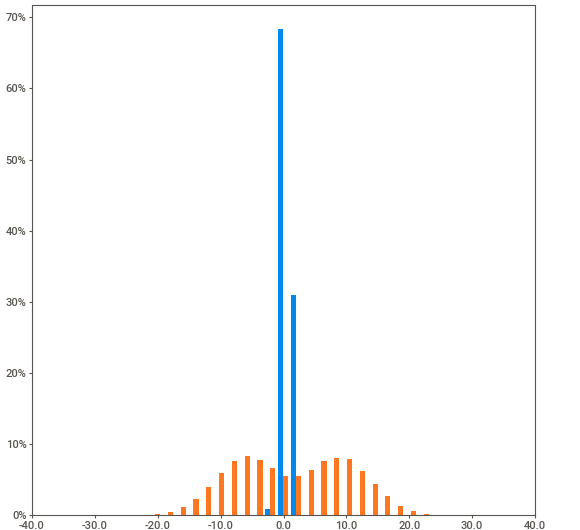
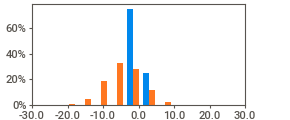
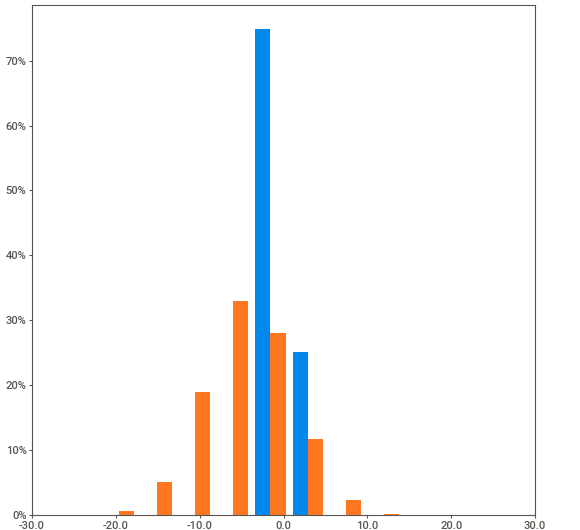
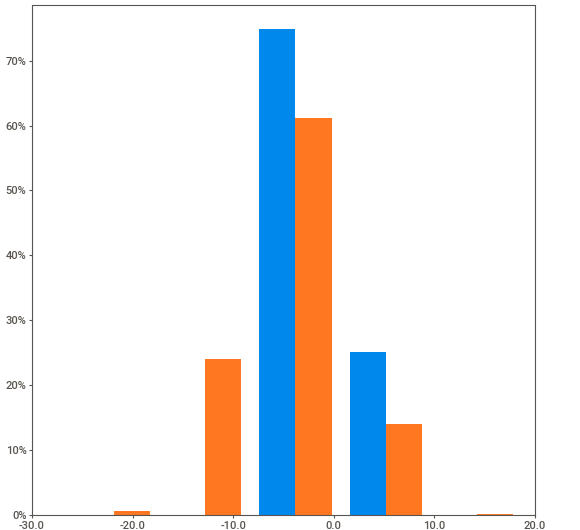
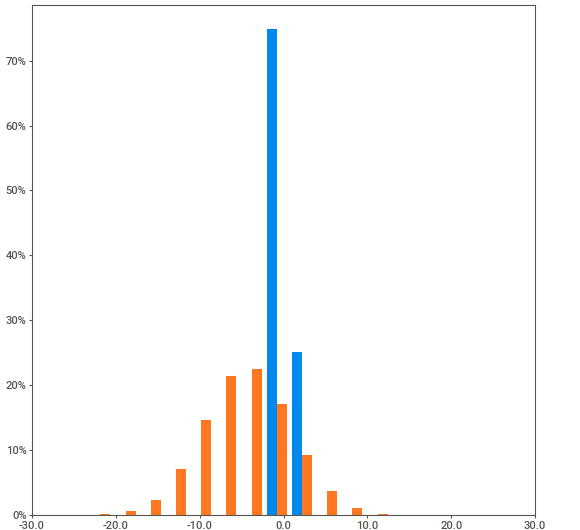
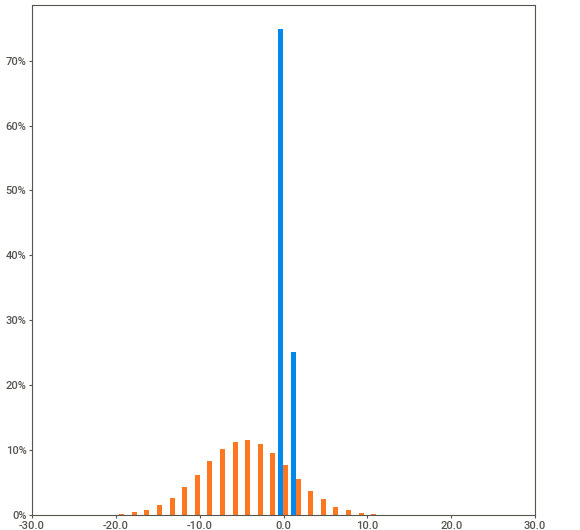
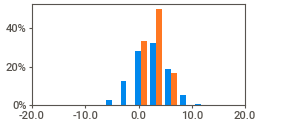
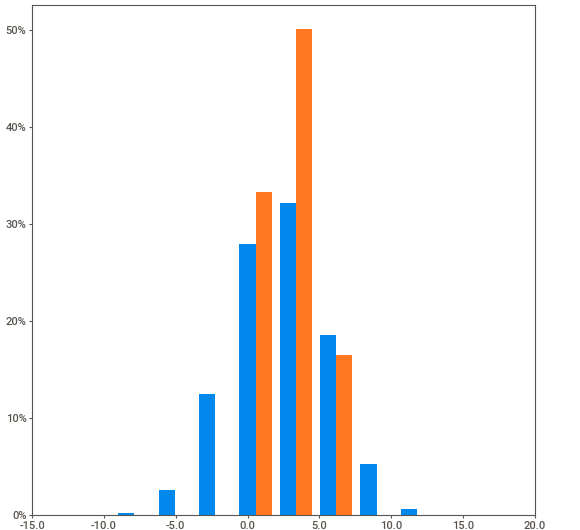
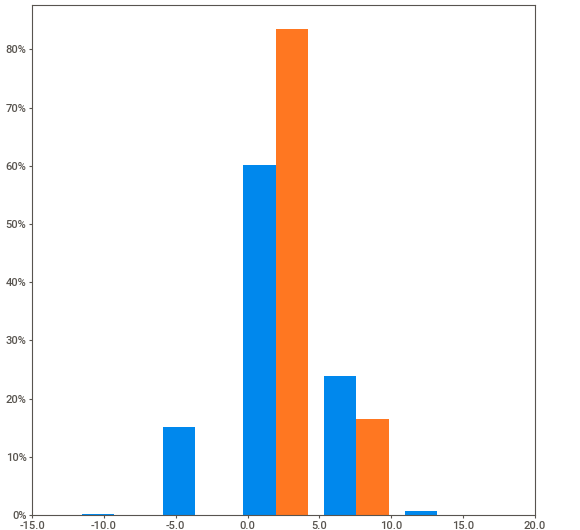
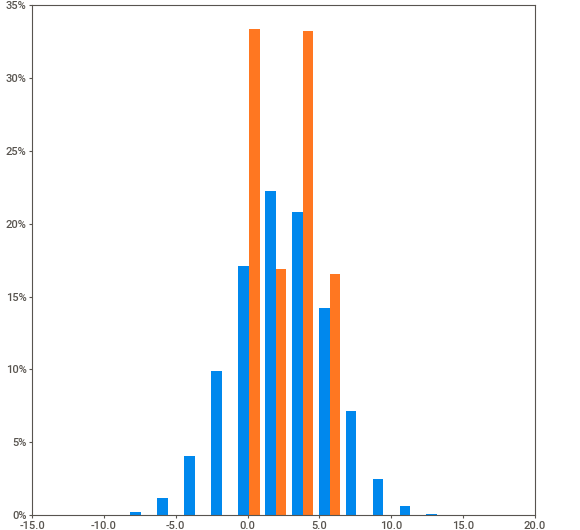
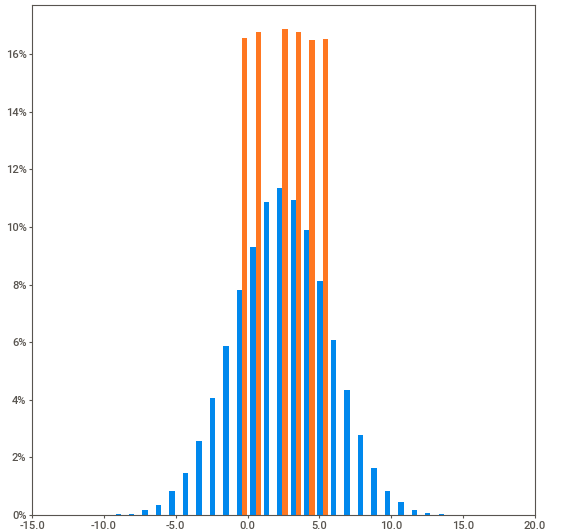
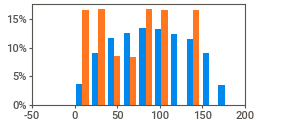
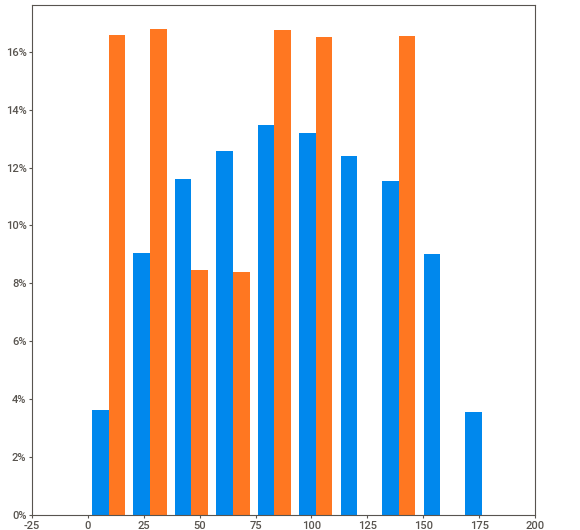
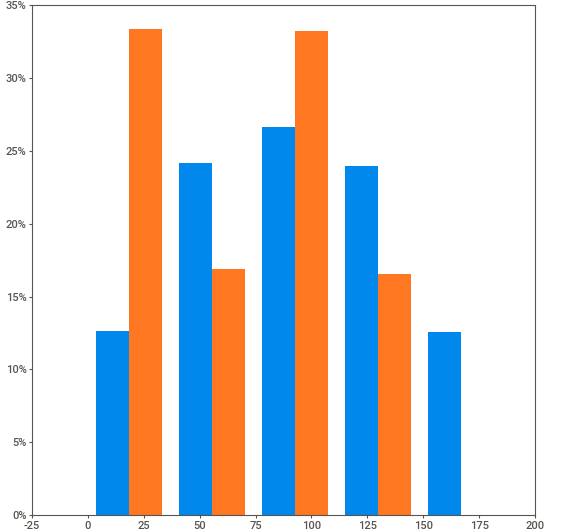
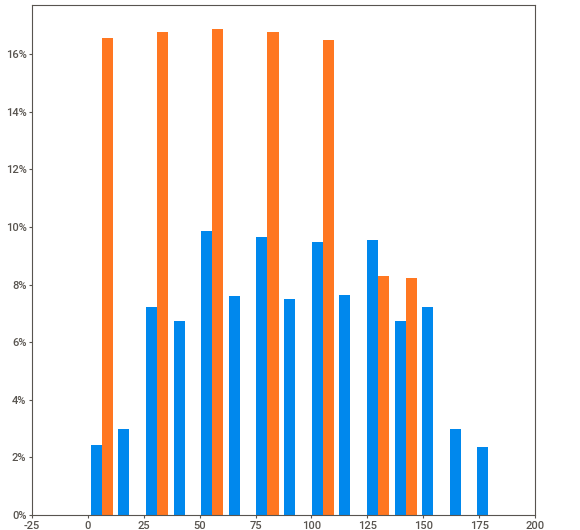
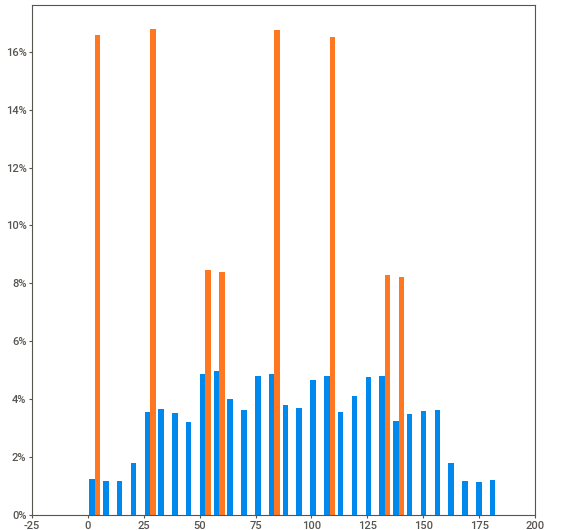
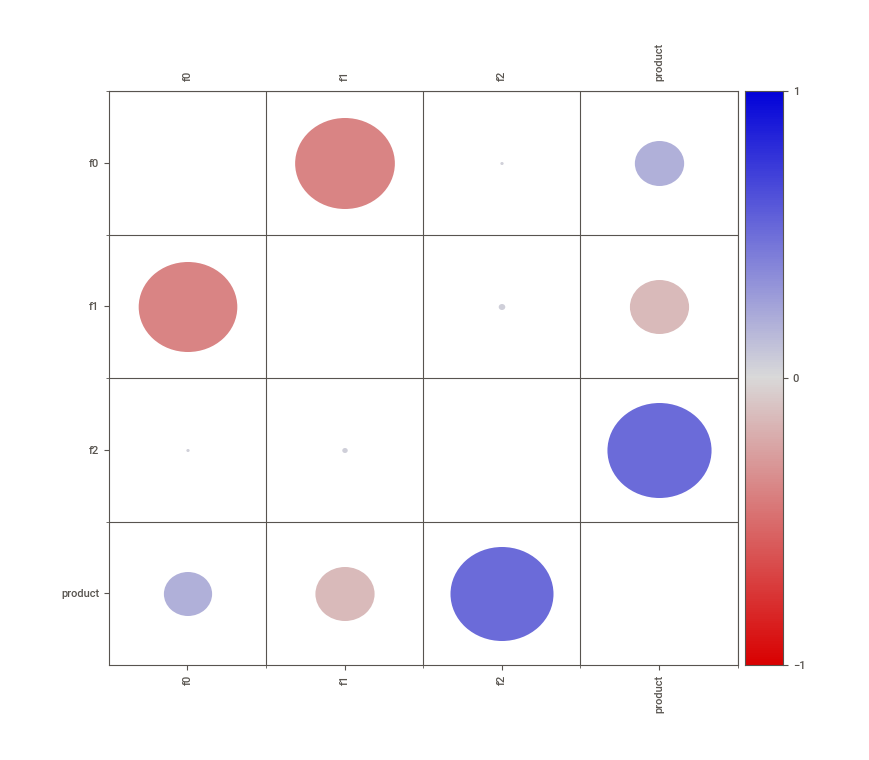
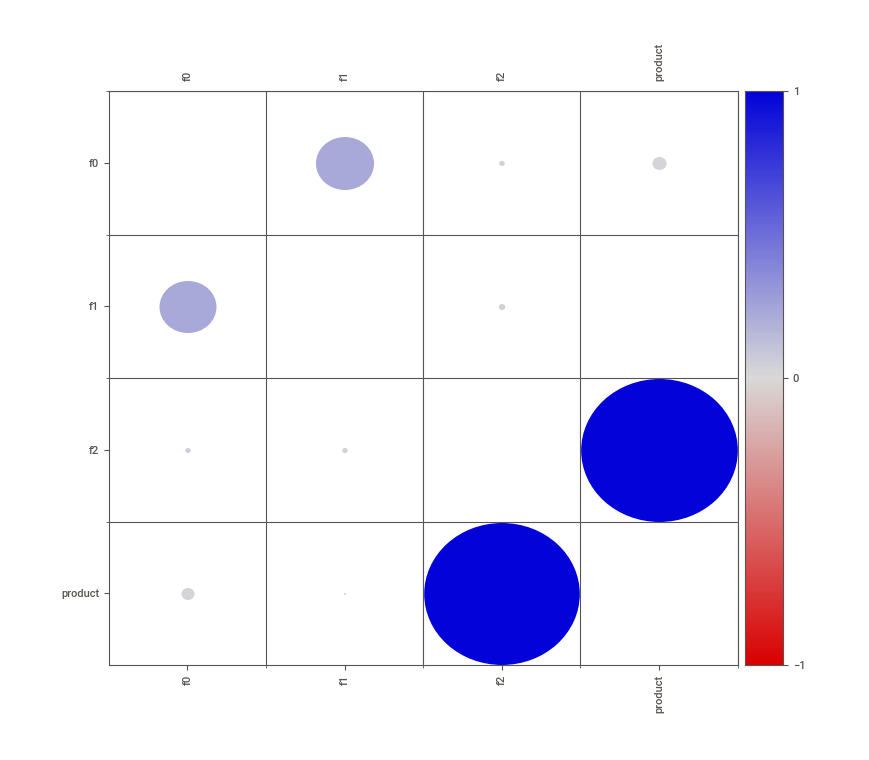

In [35]:
report_0.show_notebook()

In [36]:
report_2 = sv.analyze([data_0, "Регион 3"])

                                             |          | [  0%]   00:00 -> (? left)


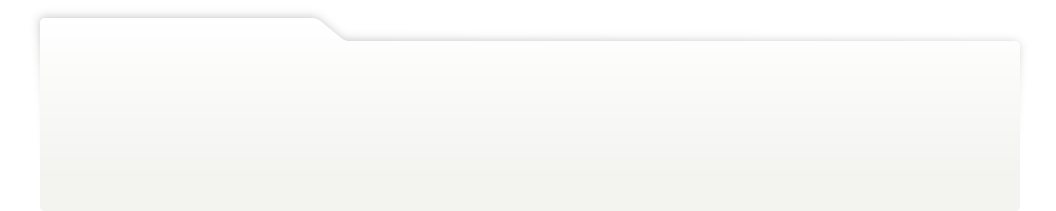
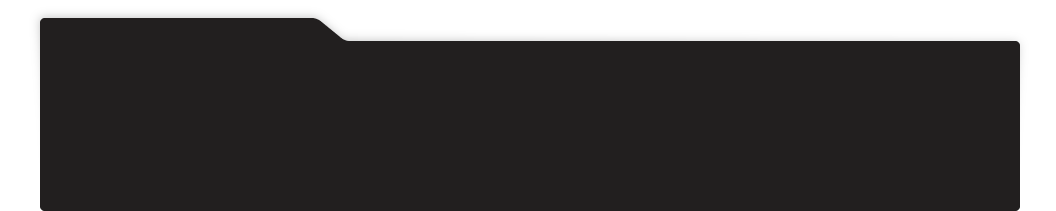
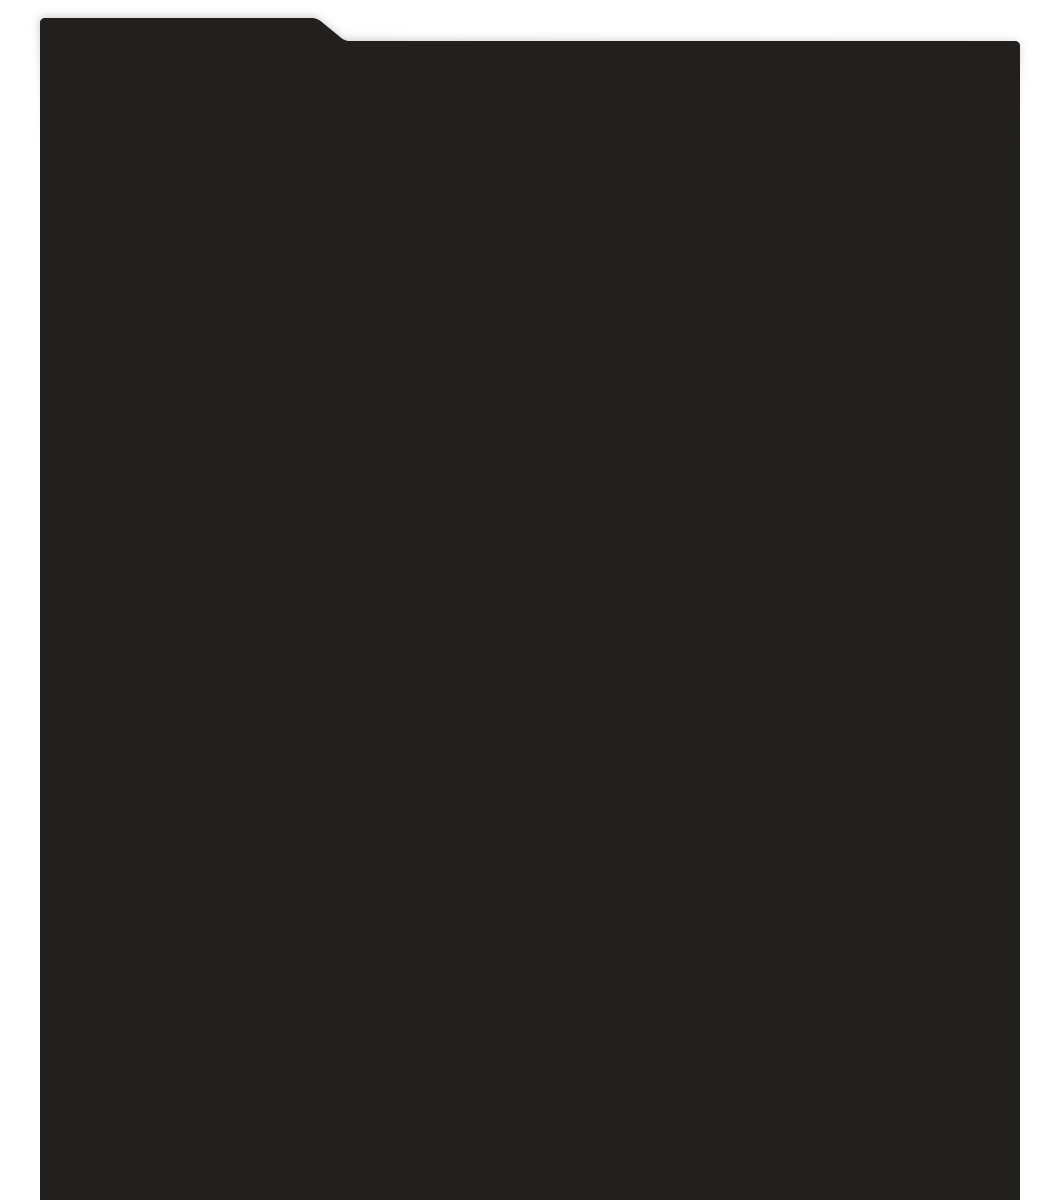
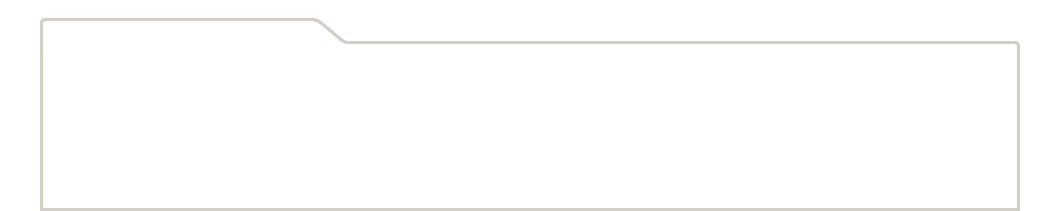
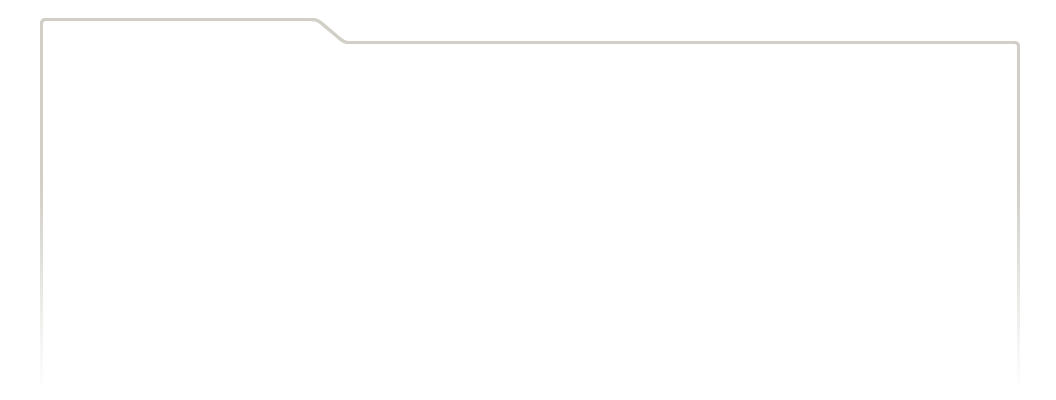
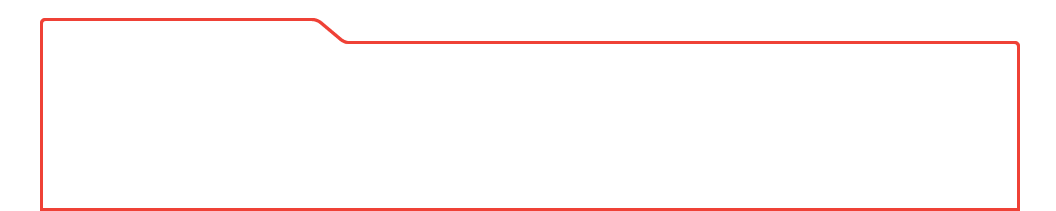
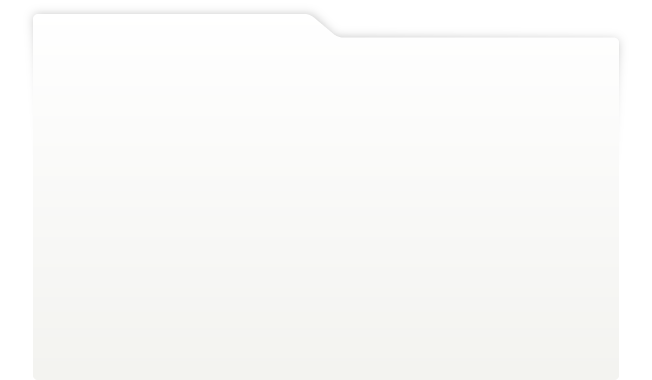
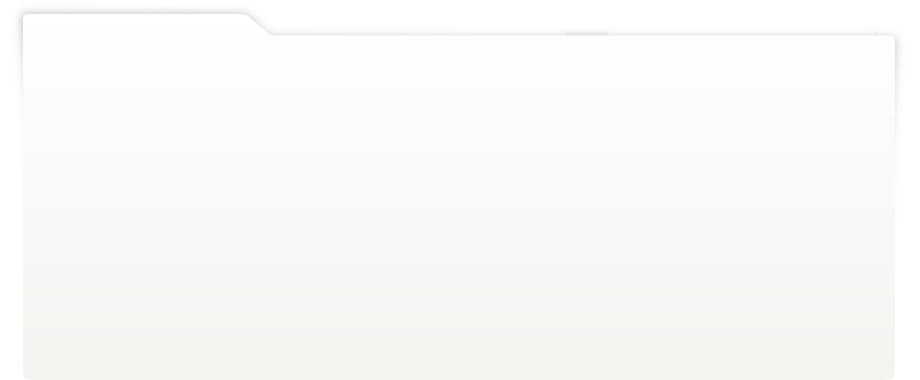
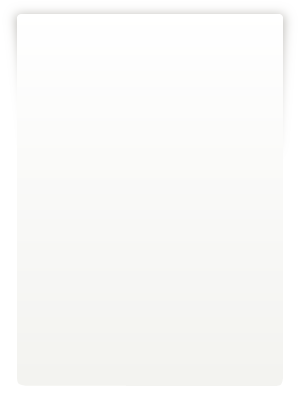
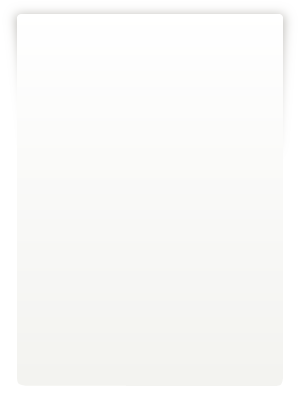
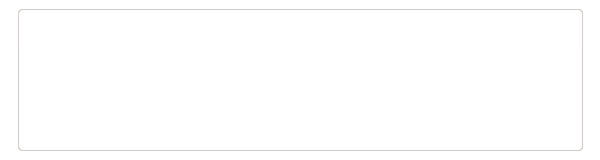
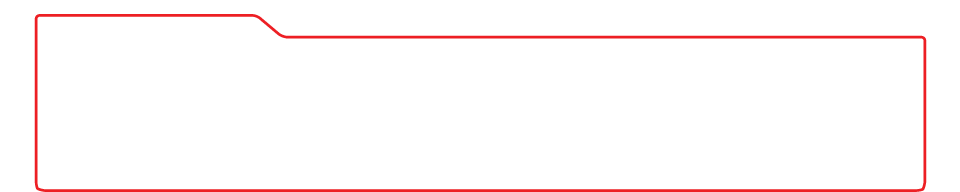
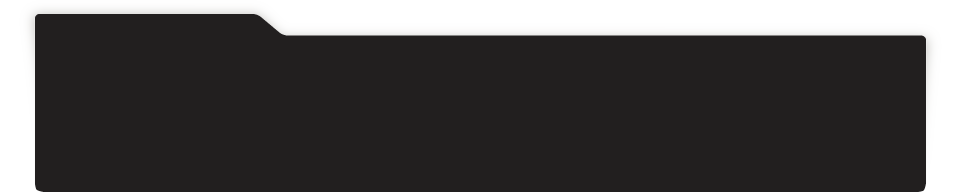
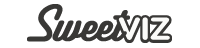
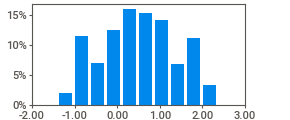
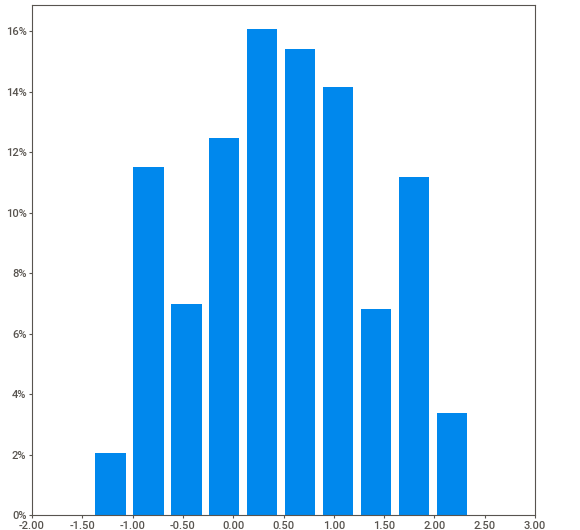
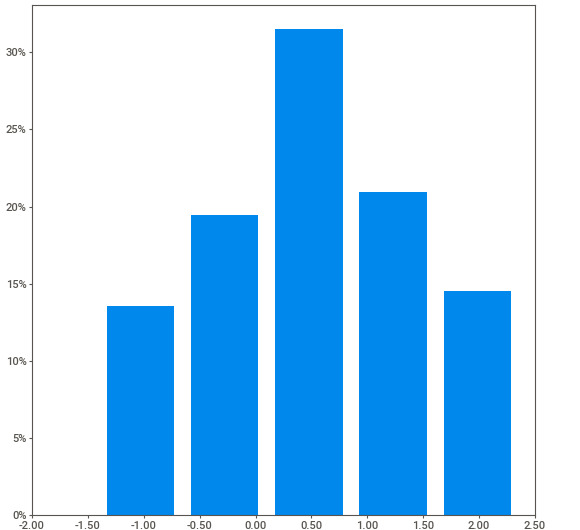
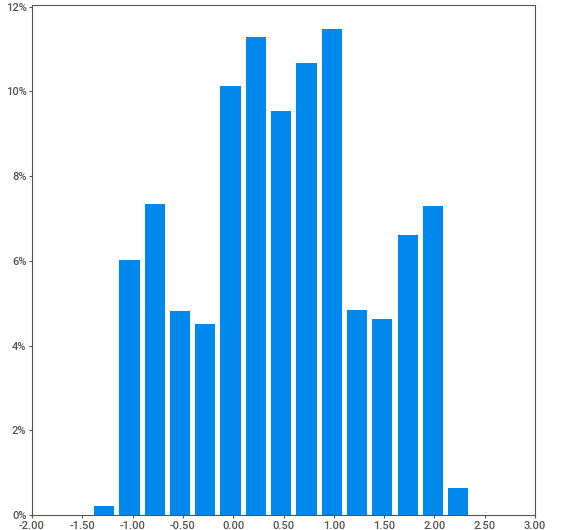
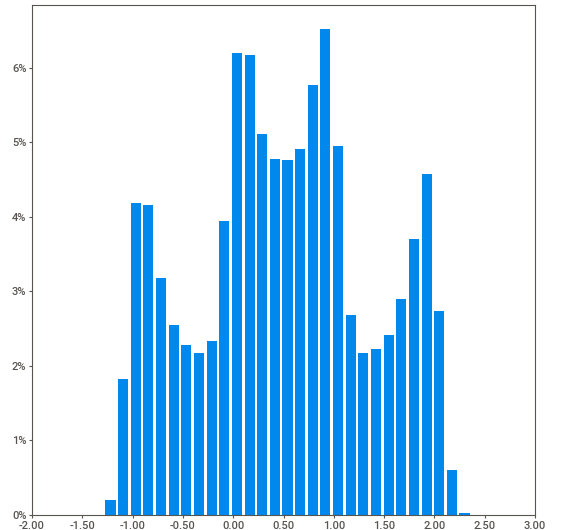
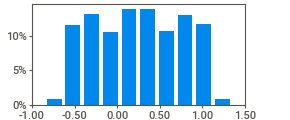
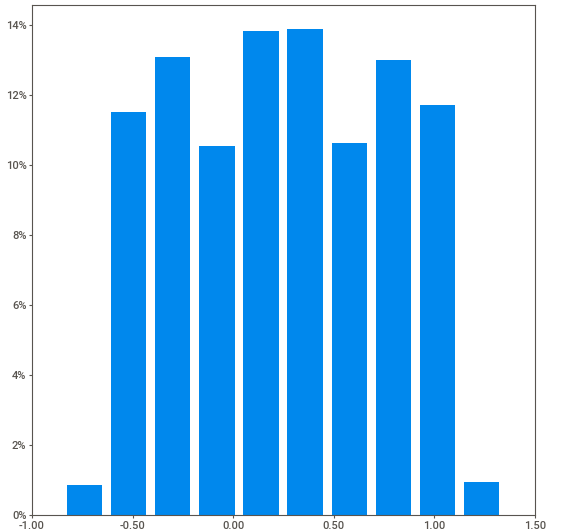
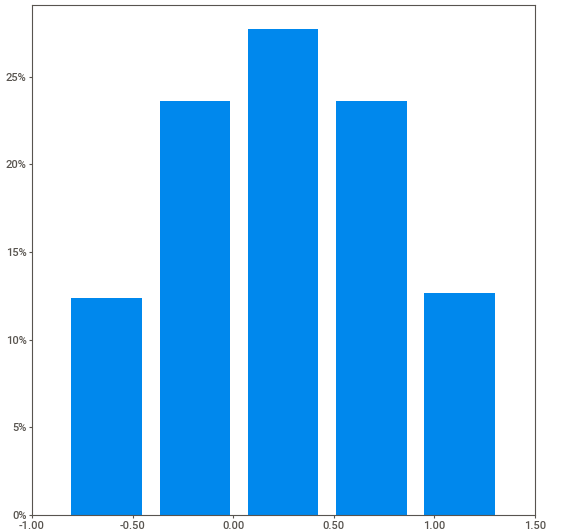
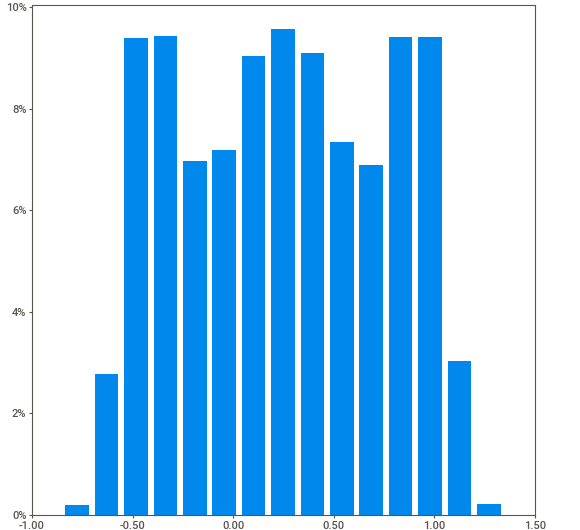
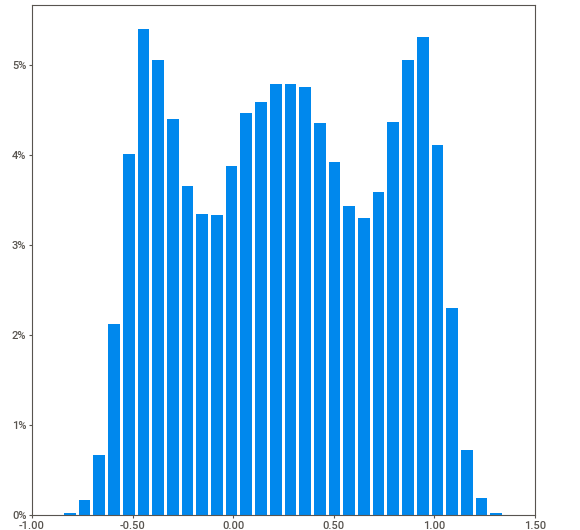
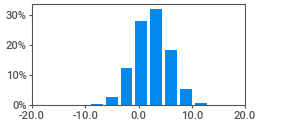
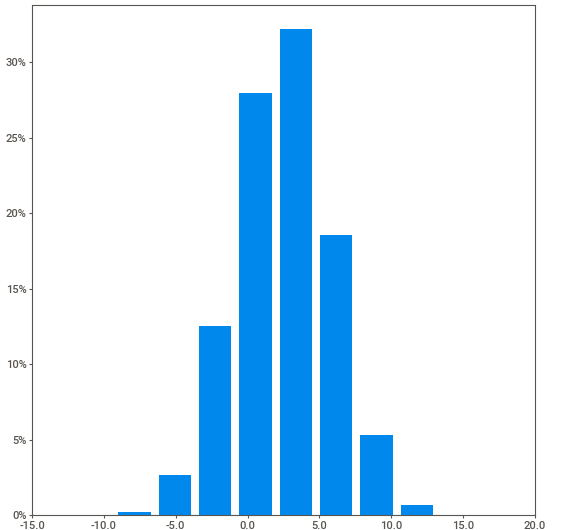
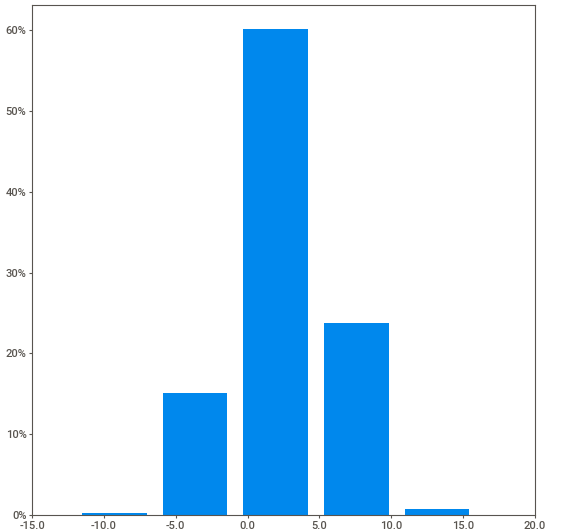
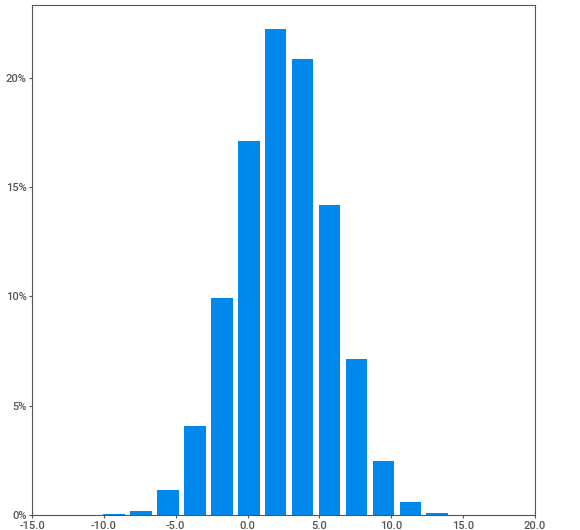
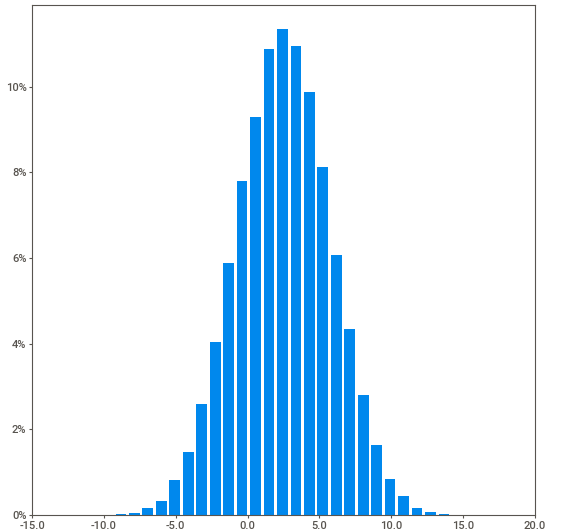
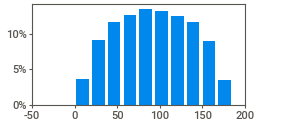
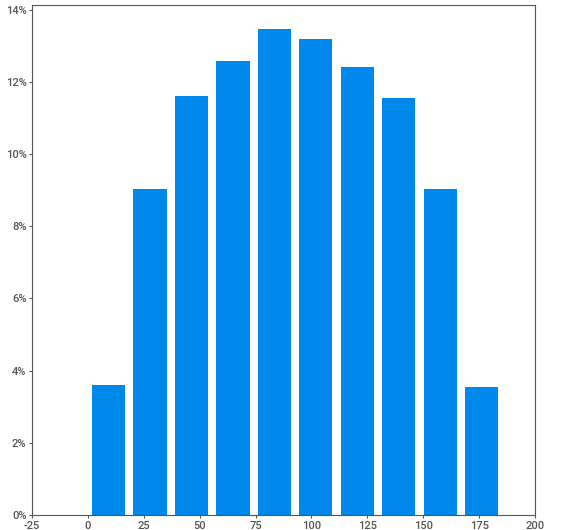
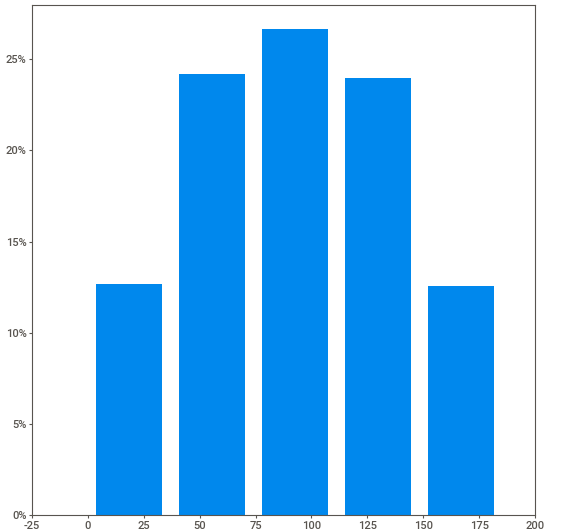
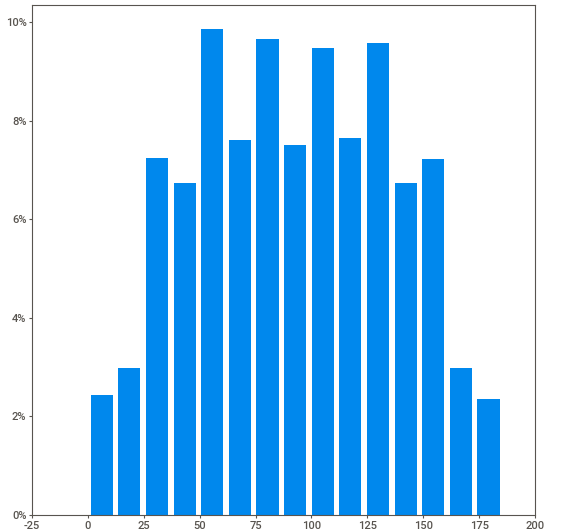
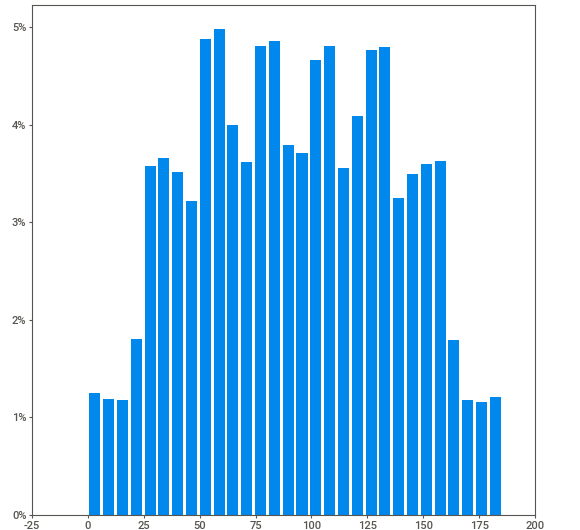
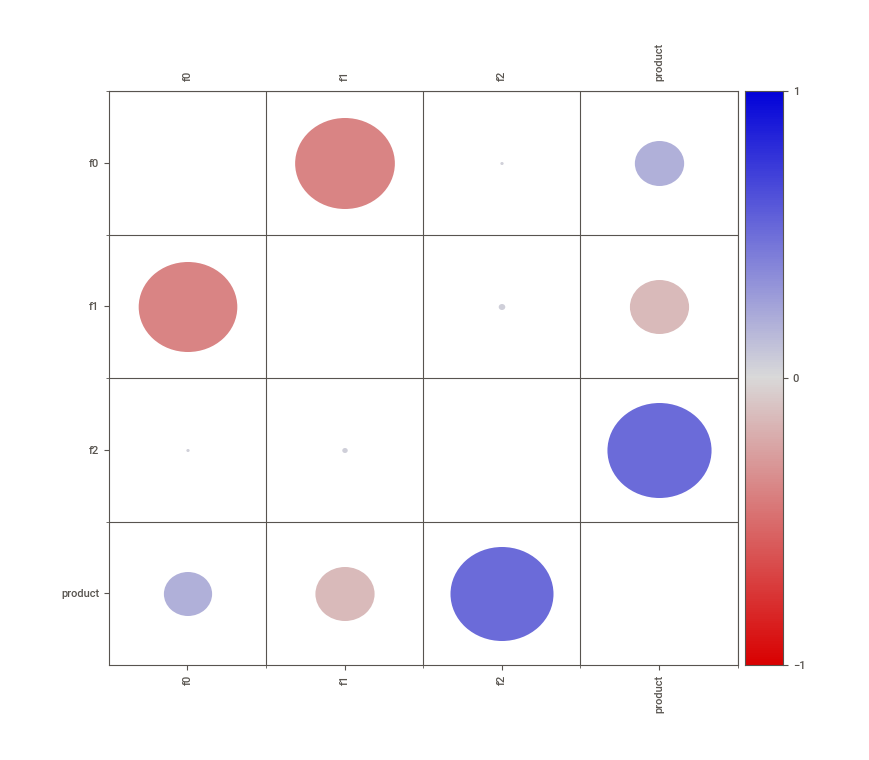
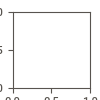

In [37]:
report_2.show_notebook()

**Итак,** имеется три датасета, в каждом по 5 колонок и 100 000 строк, пропусков нет, тип данных у признаков числовой, `id` имеет тип str. Так же во всех датасетах сильная зависимость между признаком f2 и целевым. Для построения модели колонка с `id` нам не нужна.

# Обучим и проверим модель для каждого региона

## Разделим данные на обучающую и валидационную выборки

In [38]:
def split(data):
  features = data.drop(['id', 'product'], axis=1)
  target = data['product']
  features_train,  features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
  return features_train,  features_valid, target_train, target_valid

Разделим первый датасет.

In [39]:
features_train_0,  features_valid_0, target_train_0, target_valid_0 = split(data_0)

In [40]:
features_train_0.shape, features_valid_0.shape, target_train_0.shape, target_valid_0.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Разделим данные второго датасета.

In [41]:
features_train_1,  features_valid_1, target_train_1, target_valid_1 = split(data_1)
features_train_1.shape, features_valid_1.shape, target_train_1.shape, target_valid_1.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Поделим на выборки третий датасет.

In [42]:
features_train_2,  features_valid_2, target_train_2, target_valid_2 = split(data_2)
features_train_2.shape, features_valid_2.shape, target_train_2.shape, target_valid_2.shape

((75000, 3), (25000, 3), (75000,), (25000,))

## Обучим модель и сделаем предсказания на валидационной выборке

Напишем функцию для линейной регрессии и сохранения предсказания, а так же вывожа RMSE и среднего запаса предсказанного сырья.

In [43]:
def model_predict(features_train, target_train, features_valid, target_valid):
  model = LinearRegression()
  model.fit(features_train, target_train)
  predict = model.predict(features_valid)
  print(f'Средний запас сырья: {target_valid.mean().round(2)}')
  print(f'Средний запас предсказанного сырья: {predict.mean().round(2)}')
  mse = mean_squared_error(target_valid, predict)
  print(f'RMSE: {(mse ** 0.5).round(2)}')
  print(f'Коэффициент детерминации: {r2_score(target_valid, predict).round(2)}')
  return predict

Применим функцию для первого датасета.

In [44]:
predict_0 = model_predict(features_train_0, target_train_0, features_valid_0, target_valid_0)

Средний запас сырья: 92.08
Средний запас предсказанного сырья: 92.59
RMSE: 37.58
Коэффициент детерминации: 0.28


Для второго датасета.

In [45]:
predict_1 = model_predict(features_train_1, target_train_1, features_valid_1, target_valid_1)


Средний запас сырья: 68.72
Средний запас предсказанного сырья: 68.73
RMSE: 0.89
Коэффициент детерминации: 1.0


Для третьего.

In [46]:
predict_2 = model_predict(features_train_2, target_train_2, features_valid_2, target_valid_2)


Средний запас сырья: 94.88
Средний запас предсказанного сырья: 94.97
RMSE: 40.03
Коэффициент детерминации: 0.21


### Вывод

* **Первый регион:** модель предсказала средний запас сырья 92.59, среднеквадратическая ошибка равна 37.58, а значение r2 = 0.28.
* **Второй регион:** Средний запас предсказанного сырья - 68.73, коэффициент детерминации здесь равен единице, это говорит о том, что модель предсказывает ответы практически идеально, и RMSE должно быть близко к нулю(здесь 0.89).
* **Третий регион:** здесь коэффициент детерминации даже ниже, чем в первой модели 0.21. Значение RMSE = 40.03. Средний запас сырья, который предсказала модель равен 94.97.

Видим, что лучше всего модель сработала для второго датасета(возможно из-за сильно корреляции между признаком f2 и целевым), для остальных показатели качества модели ниже. 

# Подготовимся к расчету прибыли

### Сохраним все ключевые значения для расчётов в отдельных переменных

При разведке региона исследуем 500 точек, из которых выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирем регион с наибольшей средней прибылью.

In [47]:
print('1 регион:\n* предсказания модели: "predict_0"\n* правильные ответы: "target_valid_0"')
print()
print('2 регион:\n* предсказания модели: "predict_1"\n* правильные ответы: "target_valid_1"')
print()
print('3 регион:\n* предсказания модели: "predict_2"\n* правильные ответы: "target_valid_2"')

1 регион:
* предсказания модели: "predict_0"
* правильные ответы: "target_valid_0"

2 регион:
* предсказания модели: "predict_1"
* правильные ответы: "target_valid_1"

3 регион:
* предсказания модели: "predict_2"
* правильные ответы: "target_valid_2"


Сохраним средние запасы сырья в каждом регионе.

In [48]:
product_0 = data_0['product'].mean().round(2)
product_1 = data_1['product'].mean().round(2)
product_2 = data_2['product'].mean().round(2)

In [49]:
print(f'Cредний запас сырья в 1 регионе: {product_0} млн.баррелей')
print(f'Cредний запас сырья в 2 регионе: {product_1} млн.баррелей')
print(f'Cредний запас сырья в 3 регионе: {product_2} млн.баррелей')

Cредний запас сырья в 1 регионе: 92.5 млн.баррелей
Cредний запас сырья в 2 регионе: 68.83 млн.баррелей
Cредний запас сырья в 3 регионе: 95.0 млн.баррелей


In [50]:
BUDGET = 10_000_000 # бюджет на разработку скважин, тыс. руб
REVENUE_PER_UNIT = 450 # доход с каждой единицы сырья, тыс. руб
PROBABILITY_OF_LOSS = 2.5 / 100 # вероятность убытка
BUDGET_FOR_ONE = BUDGET / 200 # бюджет на разработку одной скважины, тыс. руб
print(f'Бюджет на разработку одной скважины: {BUDGET_FOR_ONE / 1000} млн руб')

Бюджет на разработку одной скважины: 50.0 млн руб


### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [51]:
v_prod = round(BUDGET_FOR_ONE / REVENUE_PER_UNIT, 2)

In [52]:
print(f'Необходимый объем: {v_prod} тыс баррелей')

Необходимый объем: 111.11 тыс баррелей


### Сравним полученный объём сырья со средним запасом в каждом регионе. 

Рассчитаем прибыль каждой скважины в каждом регионе.

In [53]:
def profit(data):
  return (data['product'] * REVENUE_PER_UNIT).round(2)

Рассчитаем метрику ROI для каждого региона(в процентах).

In [54]:
def roi(data):
  return ((data['profit'] - BUDGET_FOR_ONE) / BUDGET_FOR_ONE * 100).round(2)

In [55]:
data_0['profit'] = profit(data_0)
data_0['roi'] = roi(data_0)

data_0.head()

,id,f0,f1,f2,product,profit,roi
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


Посмотрим сколько в среднем вложений по первому региону пока не окупилось.

In [56]:
print('Среднее значение ROI ', data_0['roi'].mean().round(2), '%', sep='')

Среднее значение ROI -16.75%


In [57]:
print('Для безубыточной разработки скважины в среднем не хватает', v_prod - product_0, 'тыс баррелей')

Для безубыточной разработки скважины в среднем не хватает 18.61 тыс баррелей


In [58]:
data_1['profit'] = profit(data_1)
data_1['roi'] = roi(data_1)

data_1.head()

,id,f0,f1,f2,product,profit,roi
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [59]:
print('Среднее значение ROI ', data_1['roi'].mean().round(2), '%', sep='')
print('Для безубыточной разработки скважины в среднем не хватает', v_prod - product_1, 'тыс баррелей')


Среднее значение ROI -38.06%
Для безубыточной разработки скважины в среднем не хватает 42.28 тыс баррелей


In [60]:
data_2['profit'] = profit(data_2)
data_2['roi'] = roi(data_2)

data_2.head()

,id,f0,f1,f2,product,profit,roi
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [61]:
print('Среднее значение ROI ', data_2['roi'].mean().round(2), '%', sep='')
print('Для безубыточной разработки скважины в среднем не хватает', v_prod - product_2, 'тыс баррелей')

Среднее значение ROI -14.5%
Для безубыточной разработки скважины в среднем не хватает 16.11 тыс баррелей


### Выводы по этапу подготовки расчёта прибыли

Для разработки одной скважины необходимо 50 млн рублей. Чтобы новая скважина была безубыточной, объем ее должен быть не менее 111 тыс баррелей. В уже имеющихся скважинах средний объем меньше необходимого, во втором регионе самый низкий показатель - 68.83. Наибольшие показатели в первом регионе.

# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выберем скважины с максимальными значениями предсказаний

Рассмотрим первый регион. Выберем 200 скважин, у которых наибольшее предсказание.

In [62]:
wells_max = pd.Series(predict_0, index=target_valid_0.index).sort_values(ascending=False)[:200]
wells_max

93073    180.180713
46784    176.252213
78948    175.850623
43388    175.658429
6496     173.299686
            ...    
30488    148.507064
98799    148.481767
53840    148.476498
4638     148.436761
75908    148.365941
Length: 200, dtype: float64

### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

In [63]:
print(f'Суммарное значение объема сырья в 200 лучших скважин: {wells_max.sum().round(2)} тыс баррелей')

Суммарное значение объема сырья в 200 лучших скважин: 31102.33 тыс баррелей


### Рассчитаем прибыль для полученного объёма сырья

In [64]:
wells_revenue = pd.Series(data_0['product'], index=wells_max.index)

In [65]:
print(f'Прибыль для полученного объема сырья: {(REVENUE_PER_UNIT * wells_revenue.sum() - BUDGET).round(2) / 1000} млн руб')


Прибыль для полученного объема сырья: 3320.82604 млн руб


### Напишем функцию для расчета прибыль в остальных регионах

In [66]:
def revenue(data, predict, target, count, k):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)[:count]
    selected = pd.Series(data['product'], index=probs_sorted.index)
    if k == 0:
       print(f'Суммарное значение объема сырья в 200 лучших скважин: {probs_sorted.sum().round(2)} тыс баррелей')
       print(f'Прибыль для полученного объема сырья: {((REVENUE_PER_UNIT * selected.sum() - BUDGET) / 1000).round(2)} млн руб')
    else:
      return (REVENUE_PER_UNIT * selected.sum() - round(BUDGET, 2))

In [68]:
revenue(data_0, predict_0, target_valid_0, 200, 0)

Суммарное значение объема сырья в 200 лучших скважин: 31102.33 тыс баррелей
Прибыль для полученного объема сырья: 3320.83 млн руб


In [69]:
revenue(data_1, predict_1, target_valid_1, 200, 0)

Суммарное значение объема сырья в 200 лучших скважин: 27746.03 тыс баррелей
Прибыль для полученного объема сырья: 2415.09 млн руб


In [70]:
revenue(data_2, predict_2, target_valid_2, 200, 0)

Суммарное значение объема сырья в 200 лучших скважин: 29603.9 тыс баррелей
Прибыль для полученного объема сырья: 2710.35 млн руб


Наибольший объем сырья по предсказаниям получается в первом регионе 31 102 тыс баррелей, а прибыль составляет почти 3.3 млрд рублей.  
Самые низкие показатели модель предсказала во втором регионе. Объем составляет 27 746 тыс баррелей, а доход почти 2.4 млрд рублей.  
Значение объема сырья в третьем регионе составляет 29 603 тыс баррелей, а прибыль 2.7 млрд руб.  
Видим, что все три региона потенциально прибыльные.

# Посчитаем риски и прибыль для каждого региона

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Функция для применения техники bootstrap, подсчета средней выручки, нахождение 95% доверительного интервала и риска убытков.

In [71]:
def bootstrap(data, target, predict):
  state = RandomState(12345)

  predict = pd.Series(predict, index=target.index)
  count = 0
  values = []
  for i in range(1000):
    target_subsample = target.sample(n=500, replace=True, random_state=state)
    probs_subsample = predict[target_subsample.index]
    values.append(revenue(data, probs_subsample, target_subsample, 200, 1))

  values = pd.Series(values)
  
  mean = values.mean() / 1000
  lower = values.quantile(0.025) / 1000
  upper = values.quantile(0.975) / 1000
  
  count = (values < 0).mean() * 100
  
  print(f'Средняя прибыль {mean.round(2)} млн рублей')
  print(f'95% доверительный интервал {lower.round(2), upper.round(2)} млн рублей')
  print(f'Процент вероятности убытка {count}%')


In [72]:
bootstrap(data_0, target_valid_0, predict_0)

Средняя прибыль 396.16 млн рублей
95% доверительный интервал (-111.22, 909.77) млн рублей
Процент вероятности убытка 6.9%


In [73]:
bootstrap(data_1, target_valid_1, predict_1)


Средняя прибыль 456.05 млн рублей
95% доверительный интервал (33.82, 852.29) млн рублей
Процент вероятности убытка 1.5%


In [74]:
bootstrap(data_2, target_valid_2, predict_2)

Средняя прибыль 404.4 млн рублей
95% доверительный интервал (-163.35, 950.36) млн рублей
Процент вероятности убытка 7.6%


### Вывод

По условию нам необходимо, чтобы вероятность убытков была не выше 2.5%. Подходит только второй регион с риском убытков 1.5% и средней прибылью 456 млн рублей. 95% доверительный интервал во втором регионе имеет значения (33.82, 852.29), то есть 95% всех доходов будет находиться в этом интервале.

# Выводы и рекомендации

В нашем распоряжении были данные по пробам нефти в трех регионах, в каждом по 10 тыс скважин. Необходимо было определить, где бурить новые скважины будет наиболее выгодно. Бюджет на одну скважину составляет 50 млн рублей, а необходимый объем для безубыточной добычи нефти - 111 тыс баррелей.  

Мы проанализировали данные и выяснили, что на данный момент средний запас сырья недостаточен для окупаемости разработки скважины. Мы построили модель линейной регрессии, которая предсказывала средний запас сырья в каждом регионе. Применили технику `bootstrap` с разделением каждого предсказанного значения прибыли по регионам на 1000 подвыборок.  

Для разработки 200 новых скважин выбран второй регион, так как только там риск убытков менее 2.5%, а именно 1.5%. Средняя прибыль там состовляет 456 млн рублей.